# Experiment Fix: Deterministic Environment Verification

## Objective
Verify that the DQN agent can learn the optimal policy in a deterministic environment (fixed schedule) with the sanitized reward function (`reward_churn = -15.0`).

This acts as a regression test to ensure that the agent isn't "terrified" of the churn penalty and can actually converge to a good policy.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from src.env import NotificationEnv, WORKER_PROFILE
from src.agents import DQNAgent
from src.baselines import OptimalStaticAgent
from src.utils import get_device

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Device: {get_device()}")

Device: mps


## 1. Environment & Agent Setup
We use the `WORKER_PROFILE` which has a consistent 9-5 work schedule.

In [2]:
# Initialize Deterministic Environment
env = NotificationEnv(
    user_profile=WORKER_PROFILE,
    reward_churn=-15.0,  # Sanitized reward
    seed=SEED
)

# Initialize DQN Agent
agent = DQNAgent(
    state_dim=env.observation_space.shape[0],
    action_dim=2,
    learning_rate=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    buffer_capacity=10000,
    batch_size=64
)

print(f"Observation Space: {env.observation_space.shape}")
print(f"Action Space: {env.action_space.n}")

Observation Space: (6,)
Action Space: 2


## 2. Baseline Evaluation
Measure the performance of the `OptimalStaticAgent` to establish a target.

In [3]:
static_agent = OptimalStaticAgent()
n_eval_episodes = 100
static_rewards = []

for _ in range(n_eval_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = static_agent.act(state, info)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state
    
    static_rewards.append(total_reward)

avg_static_reward = np.mean(static_rewards)
print(f"Optimal Static Agent Avg Reward: {avg_static_reward:.2f}")

Optimal Static Agent Avg Reward: -2.94


## 3. RL Agent Training
Train the DQN agent for 1000 episodes.

In [4]:
train_rewards = []
eval_rewards = []
eval_interval = 50

pbar = tqdm(range(1000))
for episode in pbar:
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        agent.store_transition(state, action, reward, next_state, done)
        agent.train_step()
        
        state = next_state
        total_reward += reward
    
    agent.decay_epsilon()
    if episode % 10 == 0:
        agent.update_target()
    
    train_rewards.append(total_reward)
    
    # Evaluation
    if (episode + 1) % eval_interval == 0:
        eval_scores = []
        for _ in range(10):
            s, _ = env.reset()
            r_sum = 0
            d = False
            while not d:
                a = agent.act(s, epsilon=0.0)
                ns, r, term, trunc, _ = env.step(a)
                d = term or trunc
                r_sum += r
                s = ns
            eval_scores.append(r_sum)
        
        avg_eval = np.mean(eval_scores)
        eval_rewards.append(avg_eval)
        pbar.set_description(f"Ep {episode+1} | Eval: {avg_eval:.2f} | Static: {avg_static_reward:.2f} | Eps: {agent.epsilon:.2f}")

Ep 1000 | Eval: 24.20 | Static: -2.94 | Eps: 0.05: 100%|██████████| 1000/1000 [11:06<00:00,  1.50it/s]


## 4. Results Analysis

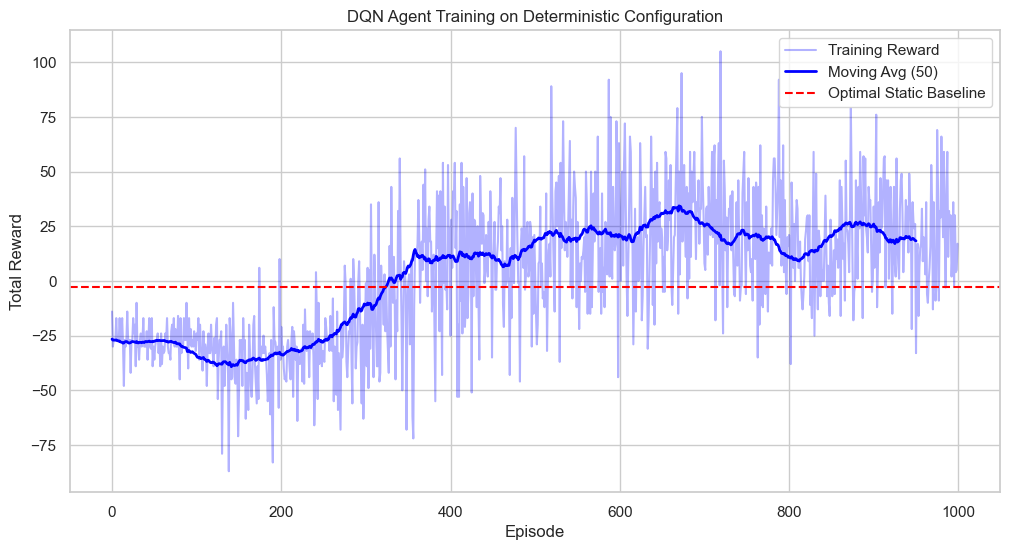

Final Eval Reward: 24.20
Success Threshold (90% of Static): -2.65
SUCCESS: Agent converged to near-optimal performance.


In [5]:
# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_rewards, label='Training Reward', alpha=0.3, color='blue')
plt.plot(np.convolve(train_rewards, np.ones(50)/50, mode='valid'), label='Moving Avg (50)', color='blue', linewidth=2)
plt.axhline(y=avg_static_reward, color='red', linestyle='--', label='Optimal Static Baseline')
plt.title('DQN Agent Training on Deterministic Configuration')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

# Final Verification
final_eval_reward = eval_rewards[-1]
success_threshold = avg_static_reward * 0.9

print(f"Final Eval Reward: {final_eval_reward:.2f}")
print(f"Success Threshold (90% of Static): {success_threshold:.2f}")

if final_eval_reward >= success_threshold:
    print("SUCCESS: Agent converged to near-optimal performance.")
else:
    print("FAILURE: Agent failed to match static baseline.")